# Nonstationary Time Series
Zhentao Shi


## Autoregressive model

* Lagged $y$ on the right-hand side

$$
y_t = \alpha + \sum_{j=1}^p \gamma_j y_{t-j} + e_t 
$$ 

can be written as 

$$
C(L) y_t = \alpha + e_t
$$ 

where 

$$
C(L) = 1 -\gamma_1 L - \cdots - \gamma_p L^p
$$ 

is a polynomial of the lag operators.

# Invertibility

If the roots of the polynomial equation $C(z) = 0$ **all** lies **outside** of the unit circle, we say the autoregressive model is invertible.



If $e_t$ is stationary with finite variance and $\alpha=0$ (homogenous difference equation):
* If the module of the smallest root is bigger than 1, $y_t$ is a stationary time series
* If the module of the smallest root is equal to 1, $y_t$ is a **unit root** process
* If the module of the smallest root is smaller than 1, $y_t$ is an **explosive** process


### Numerical Example

* $C(L) = 1 - 0.5L$ is invertible.
* $C(L) = 1 - L$ is non-invertible.
* $C(L) = 1 - 1.1L$ is non-invertible.

In [1]:
import numpy as np

def AR(b, T):
    y = np.zeros(T)
    for t in range(T):
        if t > 0:
            y[t] = b * y[t - 1] + np.random.normal()
    return y


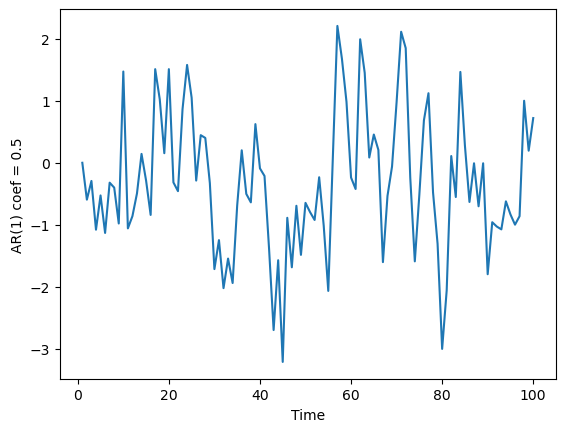

In [15]:
import matplotlib.pyplot as plt

T = 100
alpha = 0.5
y = AR(alpha, T)

plt.plot(range(1, T+1), y)
plt.xlabel("Time")
plt.ylabel(f"AR(1) coef = {alpha}")
plt.show()


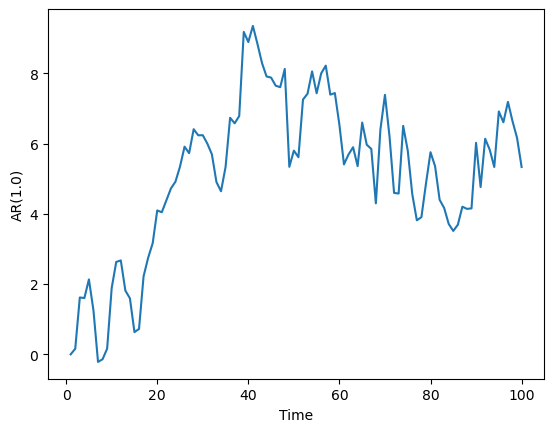

In [39]:
# import matplotlib.pyplot as plt

T = 100
y = AR(1.0, T)

plt.plot(range(1, T+1), y)
plt.xlabel("Time")
plt.ylabel("AR(1.0)")
plt.show()


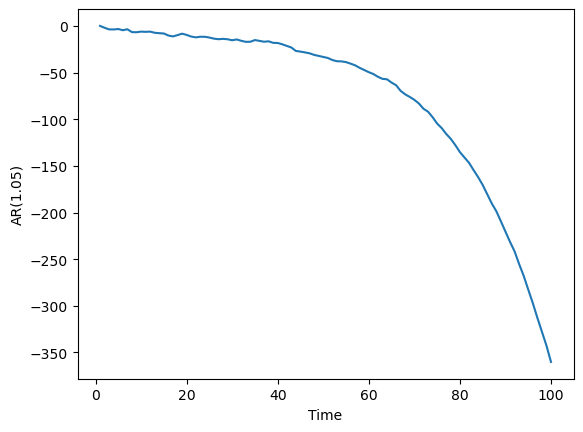

In [33]:
# import matplotlib.pyplot as plt

T = 100
y = AR(1.05, T)

plt.plot(range(1, T+1), y)
plt.xlabel("Time")
plt.ylabel("AR(1.05)")
plt.show()



# Spurious Regression


* The two time series $\{y_t\}$ and $\{x_t\}$ are generated independently, so that $E[y_t|x_t] = 0$. 
* However, we observe a high $R^2$ and large t-value if we regression $y_t$ against $x_t$.


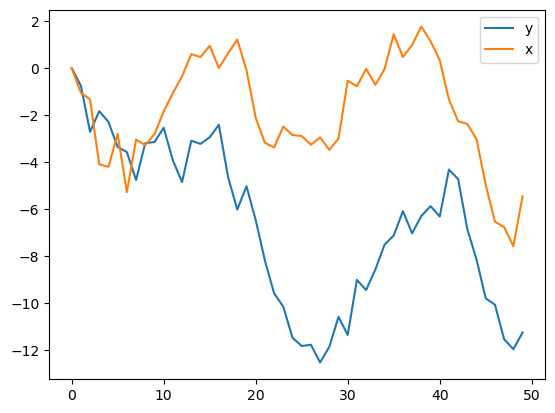

In [14]:
import matplotlib.pyplot as plt

T = 50
a = 1.0

y = AR(a, T)
x = AR(a, T)

plt.plot(y, label="y")
plt.plot(x, label="x")
plt.ylabel("")
plt.legend()
plt.show()

In [15]:
import statsmodels.api as sm

reg = sm.OLS(y, sm.add_constant(x)).fit()

print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     8.711
Date:                Fri, 14 Mar 2025   Prob (F-statistic):            0.00488
Time:                        09:53:33   Log-Likelihood:                -128.84
No. Observations:                  50   AIC:                             261.7
Df Residuals:                      48   BIC:                             265.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5142      0.596     -9.252      0.0

### Discovery

* Granger and Newbold (1974): If we naively use 1.96 as the critical value for the $t$-ratio, how often we would reject the null hypothesis that $\beta = 0$?  

* The nominal asymptotic test size is $5\%$ according to the standard asymptotic theory
* The empirical size is about 0.80 in this simulation
* The drastic deviation suggests that the standard asymptotic theory fails in the nonstationary environment.


In [16]:
import numpy as np
import pandas as pd

def spurious(i, a, T):
    y = AR(a, T)
    x = AR(a, T)

    reg = sm.OLS(y, sm.add_constant(x)).fit()
    p_val = reg.pvalues[1]
    # save the p-value of the estimate of x's coefficient
    return p_val

out = []
for i in range(1000):
    p_val = spurious(i, 1.0, 100)
    out.append(p_val)

print("rejection probability = ", np.mean(np.array(out) < 0.05))


rejection probability =  0.766


## Autoregression and Moving Average

* Box-Jenkins (1976): ARMA
* No economic theory. For fitting and prediction only.

### Simple Building Block

* White noise: $(e_t)_{t=-\infty}^{\infty}$:
    * $E[e_t] = 0$, $E[e_t^2] = \sigma_e^2$, and $E[e_t, e_s] = 0$ for all $t\neq s$. 

# ARMA


* AR(p) $$ y_t = \mu + \gamma_1 y_{t-1} + \cdots \gamma_p y_{t-p} + e_t $$
* MA(q) $$ y_t = \mu + e_t - \theta_1 e_{t-1} - \theta_q e_{t-q} + e_t $$
* ARMA(p,q) $$(1-\Gamma(L) ) y_t = \mu + \Theta (L) e_t$$

Stationarity: in AR form whether all roots lies out of the unit cycle.

# Unit Root

* AR(1) with AR coefficient equals 1. $$y_t = \mu + y_{t-1} + e_t $$
* Nonstationary
* Brownian motion: normal innovation
* Random walk

## Implication
* conditional and unconditional mean
* conditional and unconditional variance
* $h$-period ahead forecast

## Distribution
The OLS estimator 

$$
T(\hat{\gamma}_1 - 1) \stackrel{d}{\to} \text{ a stable distribution}.
$$

but the asymptotic distribution is not normal. 

### Simulation Dicky-Fuller Distribution

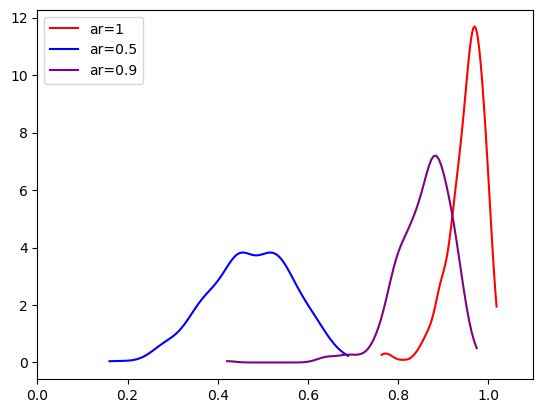

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from scipy.stats import gaussian_kde

def generate_ar_series(ar, n):
    y = np.zeros(n)
    e = np.random.randn(n)

    for i in range(1, n):
        y[i] = ar * y[i - 1] + e[i]

    return y

def DF_sim(ar):
    Rep = 500
    n = 100

    B_hat = np.zeros(Rep)

    for r in range(Rep):
        y = generate_ar_series(ar, n)
        reg_dyn = OLS(y[1:], np.vstack([np.ones(n-1), y[:-1]]).T).fit()
        B_hat[r] = reg_dyn.params[1]

    return B_hat

def plot_density(B, color, label):
    density = gaussian_kde(B)
    x = np.linspace(min(B), max(B), 100)
    plt.plot(x, density(x), color=color, label=label)

B = DF_sim(1)
plot_density(B, color="red", label="ar=1")

B = DF_sim(0.5)
plot_density(B, color="blue", label="ar=0.5")

B = DF_sim(0.9)
plot_density(B, color="purple", label="ar=0.9")

plt.xlim(0, 1.1)
plt.legend()
plt.show()

### Hypothesis Testing

* Null hypothesis: unit root.
$$ \Delta y_t = \mu + (\gamma_1 - 1 ) y_{t-1} + e_t = \mu+ \theta y_{t-1} + e_t$$
where $ \theta = \gamma_1 - 1 $. Under the null, $\theta = 0$.

* The $t$-statistic is the test statistic for the Dicky-Fuller test.
* Under the null, the $t$-statistic asymptotically follows a pivotal distribution.


## Other tests
* Phillips-Perron test
* KPSS test

# Cointegration

In a regression
$$y_t = \beta x_t  + e_t$$

* If $y_t$ and $x_t$ are I(1) series
* But a linear combination $e_t = y_t - \beta x_t $ is I(0)

then we say $y_t$ and $x_t$ are cointegrated.

In [50]:
from statsmodels.tsa.stattools import adfuller

# Calculate ADF test on residuals
adf_result = adfuller(reg.resid, autolag='AIC')

# Print summary of ADF test results
print("ADF Test Results:")
print(f"Test Statistic: {adf_result[0]}")
print(f"P-value: {adf_result[1]}")
print(f"Critical Values: {adf_result[4]}")

ADF Test Results:
Test Statistic: -1.818598251952432
P-value: 0.3712680497541245
Critical Values: {'1%': -3.436979275944879, '5%': -2.8644668170148058, '10%': -2.5683283824496153}


# Predictive Regression

In the regression 

$$
y_t = \mu_y + \beta_1 x_{t-1} + e_{yt}
$$

* $y_t$ is stationary 
* The predictor $x_t$ is highly persistent:

$$
x_t = \mu_x + \gamma x_{t-1} + e_{xt}
$$ 

with $\gamma$ is close to 1.

* Even if $E[e_{yt} | x_{t-1} ] = 0$, OLS estimator of $\beta_1$ is biased in finite sample when $e_{yt}$ and $e_{xt}$ are correlated (Stambaugh, 1999).

* Welch and Goyal: "[A Comprehensive Look at the Empirical Performance of Equity Premium Prediction](https://drive.google.com/file/d/1uvjBJ9D09T0_sp7kQppWpD-xelJ0KQhc/view)", ([dataset](https://docs.google.com/spreadsheets/d/1OArfD2Wv9IvGoLkJ8JyoXS0YMQLDZfY2/edit?usp=sharing&ouid=113571510202500088860&rtpof=true&sd=true))

* Find new behavior of popular machine learning methods in predictive regression.

#  Future of Time Series Study

* Classical methods
* Time series model for discrete choice model
* Time series dimension of big data
    * Unstructured data
    * Panel data
* Recurrent neural network, LSTM, etc...